# Random Forest - Top model according to the SCPM of -4.96

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/partner_i-Oficial/cement-shipping.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.drop(
    [
        # Removing One-Hot encoding variables
        "Cement_Type",        
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.750 (0.057)
MAE: -0.561 (0.039)
MAPE: -0.013 (0.001)
R2: 0.978 (0.002)


******
[TEST]
******
RMSE: -1.025 (0.151)
MAE: -0.782 (0.120)
MAPE: -0.018 (0.003)
R2: 0.956 (0.012)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,37.400002,37.433824,TRAIN
1,2020-01-03,36.099998,36.865510,TRAIN
2,2020-01-03,43.900002,43.475297,TRAIN
3,2020-01-03,48.500000,47.463732,TRAIN
4,2020-01-06,46.500000,46.224566,TRAIN
...,...,...,...,...
1220,2022-04-26,46.500000,47.547851,TEST
1221,2022-04-27,47.000000,47.990432,TEST
1222,2022-04-28,47.500000,47.990432,TEST
1223,2022-04-29,37.000000,37.018373,TEST


<IPython.core.display.Javascript object>

In [13]:
df_copy_copy = df_copy.copy()
df_copy_copy["Date"] = pd.to_datetime(df_copy_copy["Date"])
df_copy_copy["Date"] = df_copy_copy["Date"].dt.tz_localize(None)

df_pred_copy = df_pred.copy()
df_pred_copy["DATE"] = pd.to_datetime(df_pred_copy["DATE"])
df_pred_copy["DATE"] = df_pred_copy["DATE"].dt.tz_localize(None)

df_copy_merge = df_copy_copy.reset_index(drop=True).merge(
    df_pred_copy.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = "Partner i"
df_copy_merge["PLANT"] = "Partner i"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_btsscv_partner_i.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_btsscv_partner_i.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2020-01-02,37.400002,37.433824,TRAIN,CP II-F-32
1,2020-01-03,36.099998,36.865510,TRAIN,CP II-F-32
2,2020-01-03,43.900002,43.475297,TRAIN,CP V-ARI
3,2020-01-03,48.500000,47.463732,TRAIN,CP II-F-40
4,2020-01-06,46.500000,46.224566,TRAIN,CP II-F-40
...,...,...,...,...,...
1220,2022-04-26,46.500000,47.547851,TEST,CP V-ARI
1221,2022-04-27,47.000000,47.990432,TEST,CP II-F-40
1222,2022-04-28,47.500000,47.990432,TEST,CP V-ARI
1223,2022-04-29,37.000000,37.018373,TEST,CP II-F-32


<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

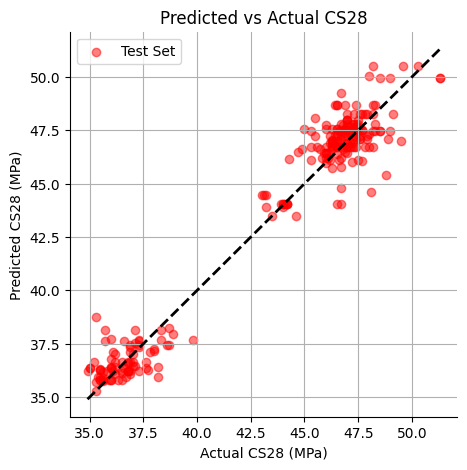

<IPython.core.display.Javascript object>

In [16]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("inn_cm_p_cs_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



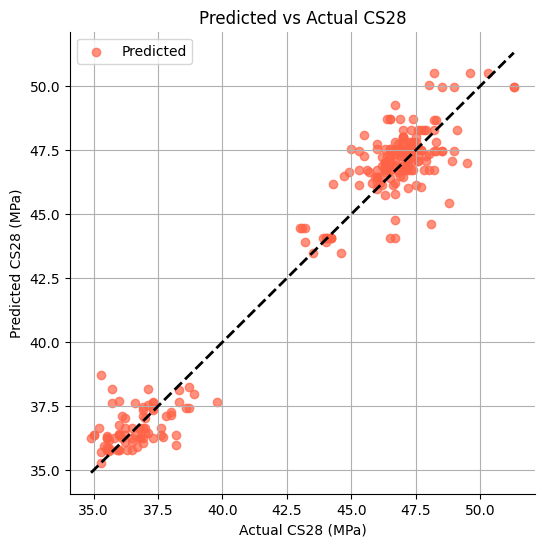

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("inn_cm_p_cs_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


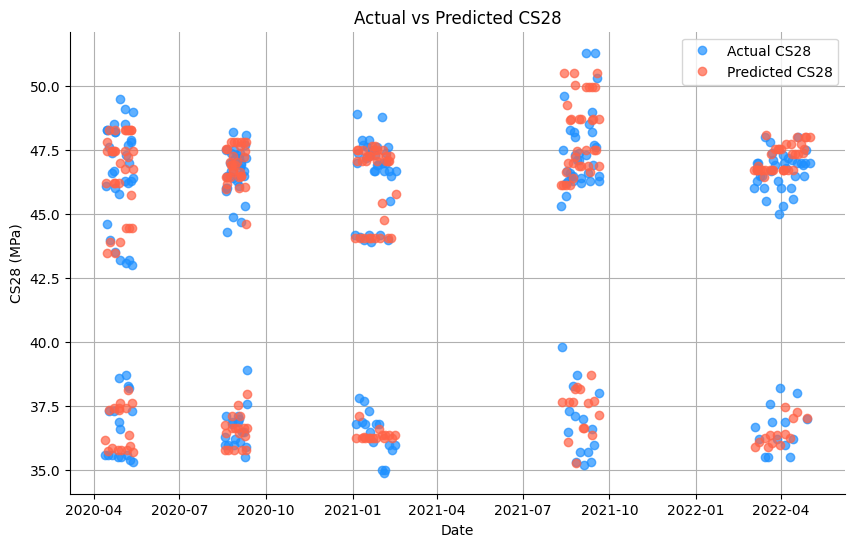

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_cs_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [19]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [20]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,CS3,CS7,#200,#325
Importances - 0,0.000043,0.017200,0.000000,0.000000,0.000814,0.000090,0.000000,0.023643,0.000329,0.000000,...,0.000000,0.000000,0.004029,0.0,0.000000,0.00000,0.180133,0.409158,0.000000,0.361690
Importances - 1,0.000420,0.001484,0.000000,0.000000,0.000000,0.009359,0.000000,0.000123,0.001091,0.000000,...,0.000000,0.002405,0.001745,0.0,0.000000,0.00000,0.396677,0.387054,0.000428,0.189245
Importances - 2,0.000000,0.003997,0.003006,0.002175,0.000000,0.001217,0.001158,0.000000,0.000121,0.000000,...,0.000000,0.000000,0.035227,0.0,0.000451,0.00000,0.379562,0.380115,0.000000,0.191306
Importances - 3,0.003591,0.000000,0.000619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000957,0.000000,0.003860,0.0,0.000000,0.00109,0.576557,0.410770,0.000634,0.000000
Importances - 4,0.000000,0.000000,0.000000,0.000680,0.002397,0.000000,0.000000,0.001693,0.000000,0.000077,...,0.000277,0.000000,0.000000,0.0,0.000000,0.00000,0.385835,0.410783,0.000000,0.194980


<IPython.core.display.Javascript object>

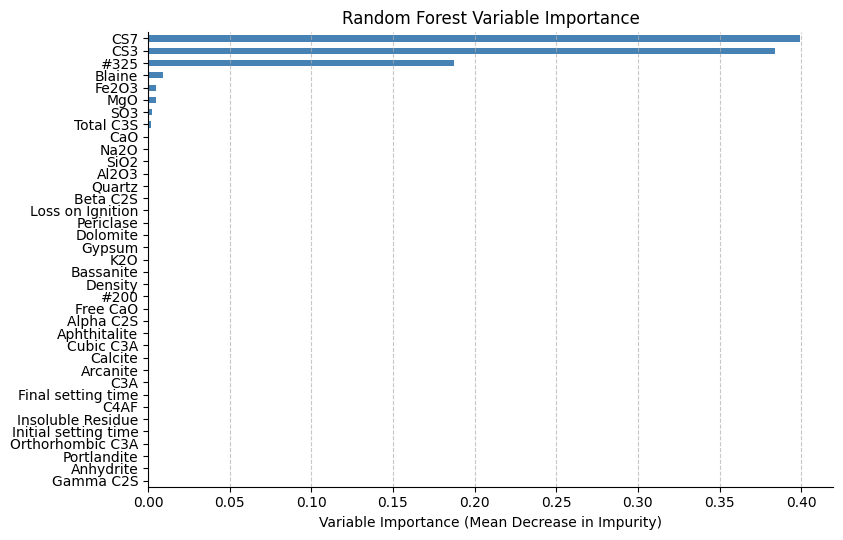

<IPython.core.display.Javascript object>

In [21]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

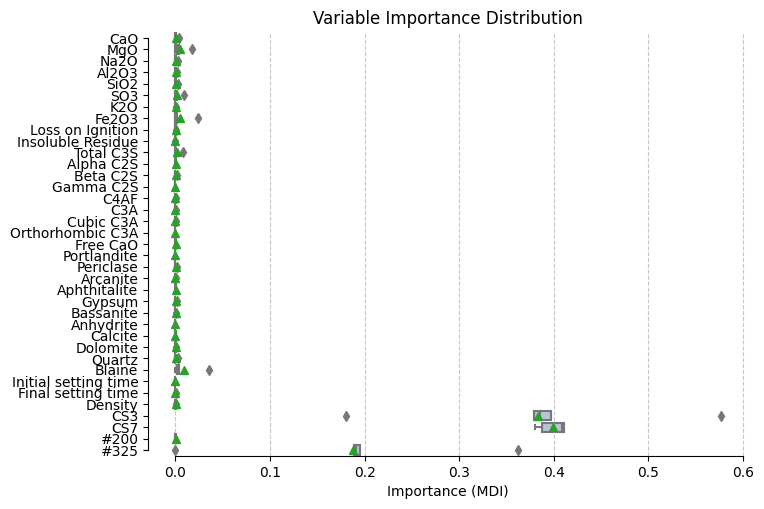

<IPython.core.display.Javascript object>

In [22]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


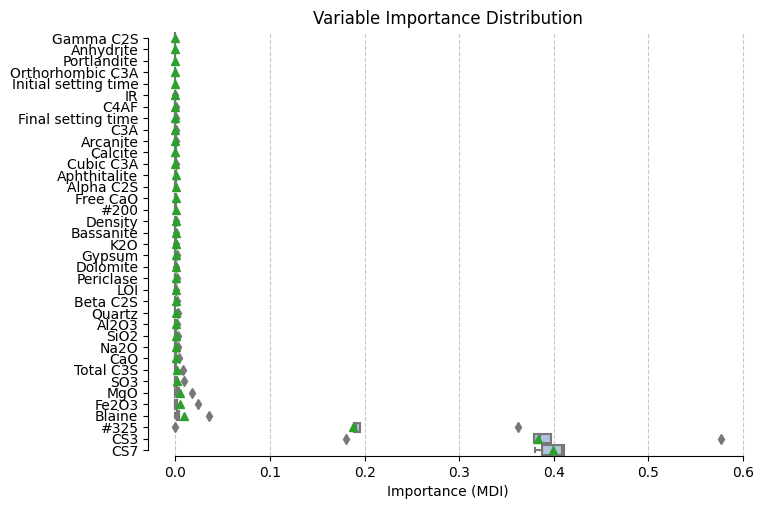

<IPython.core.display.Javascript object>

In [23]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("inn_cm_p_cs_btiss_random_forest_scpm_best_dist_var_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


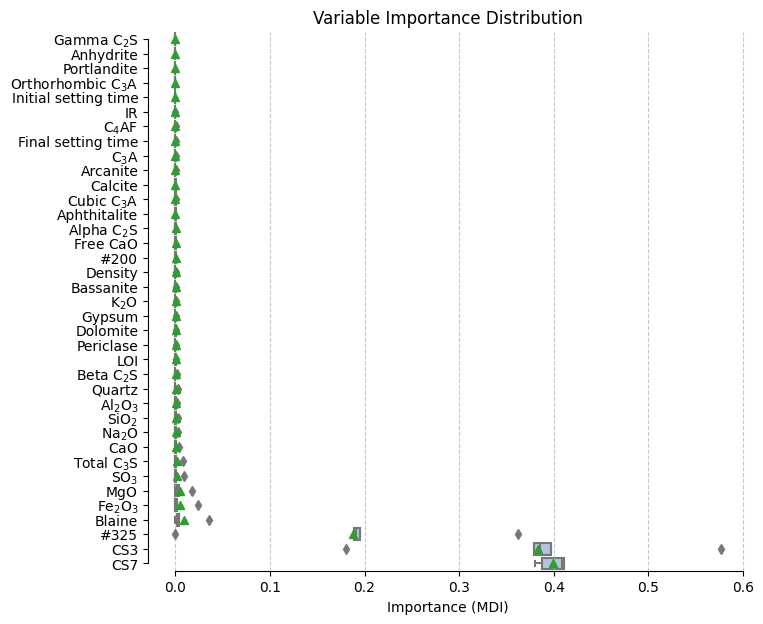

<IPython.core.display.Javascript object>

In [24]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_cs_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [25]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,CS3,CS7,#200,#325
Importances - 0,0.000043,0.017200,0.000000,0.000000,0.000814,0.000090,0.000000,0.023643,0.000329,0.000000,...,0.000000,0.000000,0.004029,0.0,0.000000,0.00000,0.180133,0.409158,0.000000,0.361690
Importances - 1,0.000420,0.001484,0.000000,0.000000,0.000000,0.009359,0.000000,0.000123,0.001091,0.000000,...,0.000000,0.002405,0.001745,0.0,0.000000,0.00000,0.396677,0.387054,0.000428,0.189245
Importances - 2,0.000000,0.003997,0.003006,0.002175,0.000000,0.001217,0.001158,0.000000,0.000121,0.000000,...,0.000000,0.000000,0.035227,0.0,0.000451,0.00000,0.379562,0.380115,0.000000,0.191306
Importances - 3,0.003591,0.000000,0.000619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000957,0.000000,0.003860,0.0,0.000000,0.00109,0.576557,0.410770,0.000634,0.000000
Importances - 4,0.000000,0.000000,0.000000,0.000680,0.002397,0.000000,0.000000,0.001693,0.000000,0.000077,...,0.000277,0.000000,0.000000,0.0,0.000000,0.00000,0.385835,0.410783,0.000000,0.194980


<IPython.core.display.Javascript object>

In [26]:
df_importances.describe().T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
Gamma C2S,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Anhydrite,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Portlandite,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Orthorhombic C3A,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Initial setting time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Insoluble Residue,5.0,0.000015,0.000034,0.000000,0.000000,0.000000,0.000000,0.000077
C4AF,5.0,0.000088,0.000196,0.000000,0.000000,0.000000,0.000000,0.000438
Final setting time,5.0,0.000090,0.000202,0.000000,0.000000,0.000000,0.000000,0.000451
C3A,5.0,0.000101,0.000225,0.000000,0.000000,0.000000,0.000000,0.000503
Arcanite,5.0,0.000101,0.000215,0.000000,0.000000,0.000000,0.000019,0.000485


<IPython.core.display.Javascript object>

In [27]:
df_importances.mean(axis=0)

CaO                     0.000811
MgO                     0.004536
Na2O                    0.000725
Al2O3                   0.000571
SiO2                    0.000642
SO3                     0.002133
K2O                     0.000232
Fe2O3                   0.005092
Loss on Ignition        0.000308
Insoluble Residue       0.000015
Total C3S               0.001781
Alpha C2S               0.000187
Beta C2S                0.000340
Gamma C2S               0.000000
C4AF                    0.000088
C3A                     0.000101
Cubic C3A               0.000127
Orthorhombic C3A        0.000000
Free CaO                0.000212
Portlandite             0.000000
Periclase               0.000247
Arcanite                0.000101
Aphthitalite            0.000167
Gypsum                  0.000245
Bassanite               0.000228
Anhydrite               0.000000
Calcite                 0.000118
Dolomite                0.000247
Quartz                  0.000481
Blaine                  0.008972
Initial se

<IPython.core.display.Javascript object>

In [28]:
df_importances.std(axis=0, ddof=0)

CaO                     0.001399
MgO                     0.006498
Na2O                    0.001166
Al2O3                   0.000844
SiO2                    0.000932
SO3                     0.003642
K2O                     0.000463
Fe2O3                   0.009298
Loss on Ignition        0.000409
Insoluble Residue       0.000031
Total C3S               0.003343
Alpha C2S               0.000249
Beta C2S                0.000680
Gamma C2S               0.000000
C4AF                    0.000175
C3A                     0.000201
Cubic C3A               0.000177
Orthorhombic C3A        0.000000
Free CaO                0.000260
Portlandite             0.000000
Periclase               0.000494
Arcanite                0.000192
Aphthitalite            0.000136
Gypsum                  0.000491
Bassanite               0.000457
Anhydrite               0.000000
Calcite                 0.000152
Dolomite                0.000371
Quartz                  0.000962
Blaine                  0.013211
Initial se

<IPython.core.display.Javascript object>

In [29]:
df_copy.nunique()

Date                     651
CaO                     1215
MgO                     1216
Na2O                    1107
Al2O3                   1208
SiO2                    1213
SO3                     1213
K2O                     1178
Fe2O3                   1207
Loss on Ignition         579
Insoluble Residue        410
Total C3S                882
Alpha C2S                335
Beta C2S                 626
Gamma C2S                178
C4AF                     451
C3A                      310
Cubic C3A                278
Orthorhombic C3A         204
Free CaO                 167
Portlandite              292
Periclase                247
Arcanite                 267
Aphthitalite             104
Gypsum                   383
Bassanite                472
Anhydrite                 48
Calcite                  810
Dolomite                 293
Quartz                   256
Blaine                   349
Initial setting time      17
Final setting time        17
Density                   10
CS3           

<IPython.core.display.Javascript object>

In [30]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [31]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [32]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

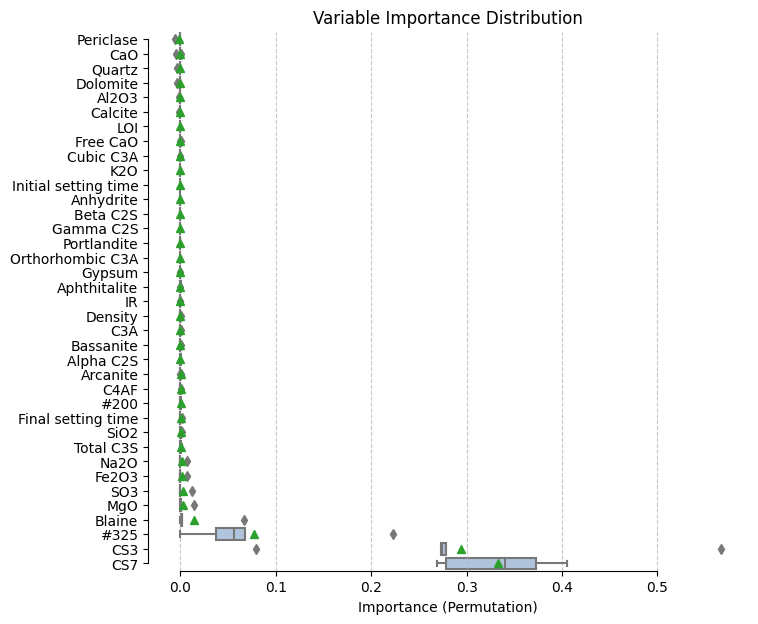

<IPython.core.display.Javascript object>

In [33]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 7))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_cs_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

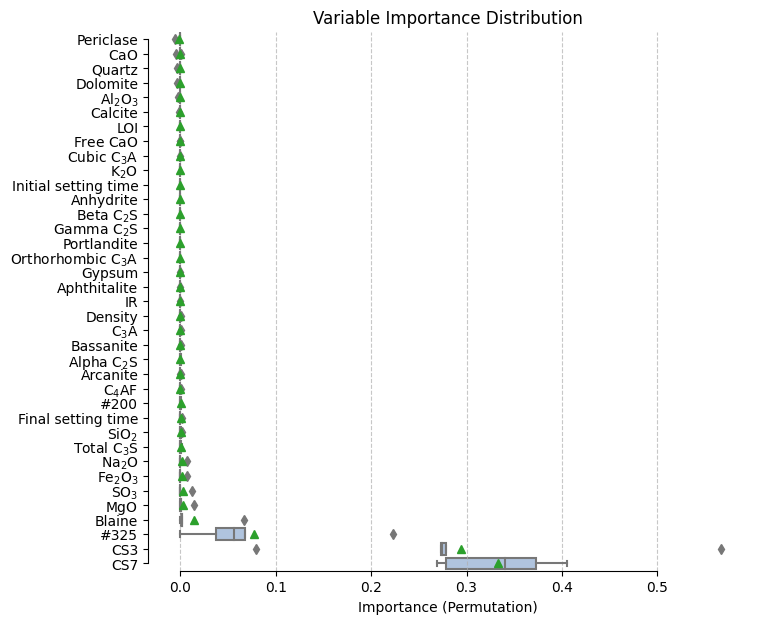

<IPython.core.display.Javascript object>

In [34]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_cs_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [35]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Periclase,5.0,-0.001052,0.002352,-0.005260,0.000000,0.000000,0.000000,0.000000
CaO,5.0,-0.000768,0.002213,-0.004606,-0.000329,0.000000,0.000000,0.001098
Quartz,5.0,-0.000688,0.001537,-0.003438,0.000000,0.000000,0.000000,0.000000
Dolomite,5.0,-0.000620,0.001386,-0.003099,0.000000,0.000000,0.000000,0.000000
Al2O3,5.0,-0.000391,0.000874,-0.001955,0.000000,0.000000,0.000000,0.000000
Calcite,5.0,-0.000336,0.000539,-0.001237,-0.000445,0.000000,0.000000,0.000000
LOI,5.0,-0.000209,0.000287,-0.000556,-0.000488,0.000000,0.000000,0.000000
Free CaO,5.0,-0.000136,0.000391,-0.000826,0.000000,0.000000,0.000000,0.000146
Cubic C3A,5.0,-0.000004,0.000010,-0.000021,0.000000,0.000000,0.000000,0.000000
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [36]:
perm_importances_df

,Periclase,CaO,Quartz,Dolomite,Al2O3,Calcite,LOI,Free CaO,Cubic C3A,K2O,...,SiO2,Total C3S,Na2O,Fe2O3,SO3,MgO,Blaine,#325,CS3,CS7
0,0.00000,-0.000329,0.000000,0.000000,0.000000,0.000000,-0.000556,-0.000826,-0.000021,0.0,...,0.000182,0.000000,0.000000,0.007015,0.000040,0.014382,0.000582,0.223278,0.079157,0.405741
1,0.00000,0.001098,-0.003438,0.000000,0.000000,-0.000445,-0.000488,0.000000,0.000000,0.0,...,0.000000,0.001566,0.000000,0.000000,0.012412,0.000922,0.001357,0.037753,0.274227,0.278597
2,0.00000,0.000000,0.000000,0.000000,-0.001955,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.006812,0.000000,-0.000020,0.000265,0.066950,0.067795,0.273478,0.269163
3,0.00000,-0.004606,0.000000,-0.003099,0.000000,-0.001237,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002005,0.000000,0.566479,0.372927
4,-0.00526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000146,0.000000,0.0,...,0.001539,0.001010,0.000000,0.000100,0.000000,0.000000,0.000000,0.055780,0.278173,0.340103


<IPython.core.display.Javascript object>

In [37]:
perm_importances_df.mean(axis=0)

Periclase              -0.001052
CaO                    -0.000768
Quartz                 -0.000688
Dolomite               -0.000620
Al2O3                  -0.000391
Calcite                -0.000336
LOI                    -0.000209
Free CaO               -0.000136
Cubic C3A              -0.000004
K2O                     0.000000
Initial setting time    0.000000
Anhydrite               0.000000
Beta C2S                0.000000
Gamma C2S               0.000000
Portlandite             0.000000
Orthorhombic C3A        0.000000
Gypsum                  0.000007
Aphthitalite            0.000014
IR                      0.000020
Density                 0.000039
C3A                     0.000041
Bassanite               0.000097
Alpha C2S               0.000102
Arcanite                0.000142
C4AF                    0.000151
#200                    0.000168
Final setting time      0.000307
SiO2                    0.000344
Total C3S               0.000515
Na2O                    0.001362
Fe2O3     

<IPython.core.display.Javascript object>

In [38]:
perm_importances_df.std(axis=0, ddof=0)

Periclase               0.002104
CaO                     0.001979
Quartz                  0.001375
Dolomite                0.001240
Al2O3                   0.000782
Calcite                 0.000482
LOI                     0.000257
Free CaO                0.000350
Cubic C3A               0.000009
K2O                     0.000000
Initial setting time    0.000000
Anhydrite               0.000000
Beta C2S                0.000000
Gamma C2S               0.000000
Portlandite             0.000000
Orthorhombic C3A        0.000000
Gypsum                  0.000014
Aphthitalite            0.000234
IR                      0.000039
Density                 0.000077
C3A                     0.000082
Bassanite               0.000194
Alpha C2S               0.000127
Arcanite                0.000367
C4AF                    0.000302
#200                    0.000215
Final setting time      0.000613
SiO2                    0.000602
Total C3S               0.000655
Na2O                    0.002725
Fe2O3     

<IPython.core.display.Javascript object>

In [39]:
from sklearn.metrics import make_scorer

def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame({
        "RMSE Test": [rmse],
        "MAE Test": [mae],
        "MAPE Test": [mape],
        "R2 Test": [r2]
    })

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

# Convert the SCPM function to a scorer that can be used in permutation_importance
scmp_scorer = make_scorer(compute_scmp, greater_is_better=False)


<IPython.core.display.Javascript object>